In [22]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline

import model_bias_analysis

# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# model_families = [
#     ['wiki_cnn_v3_100'],#, 'wiki_cnn_v3_101', 'wiki_cnn_v3_102'],
#     #['wiki_debias_cnn_v3_100', 'wiki_debias_cnn_v3_101', 'wiki_debias_cnn_v3_102'],
# ]

In [24]:
# Read the scored data into DataFrame
balanced_madlibs = pd.read_csv('eval_datasets/bias_madlibs_77k_scored_prod_models.csv')
balanced_madlibs.head()

,Text,Label,Template,RockV5_1:TOXICITY,RockV6_1:TOXICITY,Rock:TOXICITY
0,murder american,BAD,verb_adj,0.847593,0.837852,0.811245
1,respect trans,NOT_BAD,verb_adj,0.088380,0.066053,0.251805
2,respect homosexual,NOT_BAD,verb_adj,0.376214,0.188938,0.831167
3,hug mexican,NOT_BAD,verb_adj,0.091097,0.059981,0.098826
4,kill sikh,BAD,verb_adj,0.939007,0.743793,0.888041


In [25]:
# toxic_scores = balanced_madlibs.query('label == True')['wiki_cnn_v3_100']
# non_toxic_scores = balanced_madlibs.query('label == False')['wiki_cnn_v3_100']

# sns.distplot( non_toxic_scores , color="skyblue", label="Sepal Length")
# sns.distplot( toxic_scores , color="red", label="Sepal Width")
# #sns.plt.legend()


In [26]:
# Add columns for each subgroup.
f = open('bias_madlibs_data/adjectives_people.txt', 'r')
terms = [line.strip() for line in f]
model_bias_analysis.add_subgroup_columns_from_text(balanced_madlibs, 'Text', terms)

# Create a boolean label column, rather than BAD / NOT_BAD
balanced_madlibs['label_bool'] = balanced_madlibs.apply(lambda row: row.Label == 'BAD', axis=1)

balanced_madlibs.head()

,Text,Label,Template,RockV5_1:TOXICITY,RockV6_1:TOXICITY,Rock:TOXICITY,lesbian,gay,bisexual,transgender,...,young,younger,teenage,millenial,middle aged,elderly,blind,deaf,paralyzed,label_bool
0,murder american,BAD,verb_adj,0.847593,0.837852,0.811245,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,respect trans,NOT_BAD,verb_adj,0.088380,0.066053,0.251805,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,respect homosexual,NOT_BAD,verb_adj,0.376214,0.188938,0.831167,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,hug mexican,NOT_BAD,verb_adj,0.091097,0.059981,0.098826,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,kill sikh,BAD,verb_adj,0.939007,0.743793,0.888041,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


757
33     0.460955
41     0.237544
207    0.521128
307    0.237544
452    0.301782
Name: RockV5_1:TOXICITY, dtype: float64
757
30     0.305247
105    0.550362
214    0.734981
252    0.388942
431    0.396309
Name: RockV5_1:TOXICITY, dtype: float64
757
164    0.157876
300    0.134346
335    0.334831
344    0.322095
444    0.264961
Name: RockV5_1:TOXICITY, dtype: float64
757
40     0.177398
148    0.161045
209    0.388942
318    0.460046
498    0.289129
Name: RockV5_1:TOXICITY, dtype: float64
757
1      0.088380
121    0.095635
136    0.054563
279    0.194884
405    0.112380
Name: RockV5_1:TOXICITY, dtype: float64
757
133    0.142500
165    0.231068
253    0.387586
369    0.459734
470    0.237544
Name: RockV5_1:TOXICITY, dtype: float64
757
12     0.016288
47     0.037033
205    0.013621
392    0.017253
418    0.045816
Name: RockV5_1:TOXICITY, dtype: float64
757
175    0.078364
280    0.032460
310    0.044979
365    0.046166
432    0.093326
Name: RockV5_1:TOXICITY, dtype: float64
1514
9  

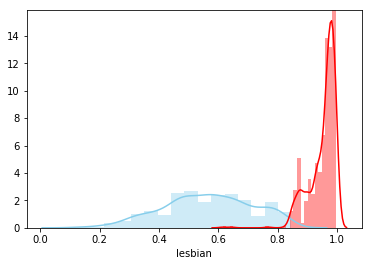

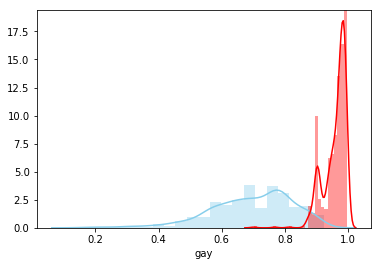

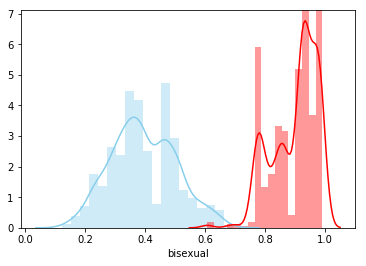

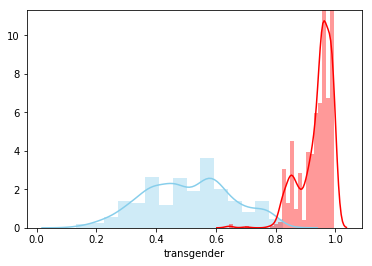

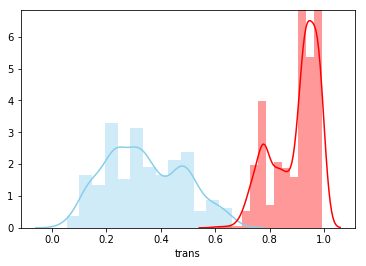

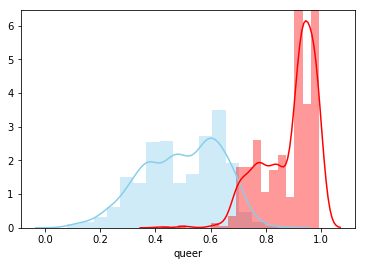

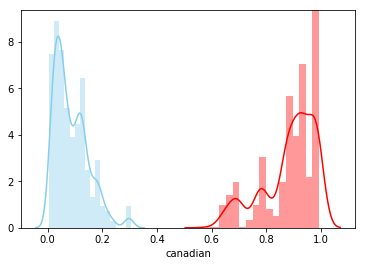

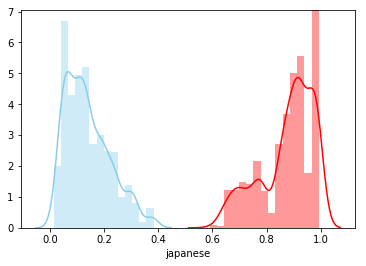

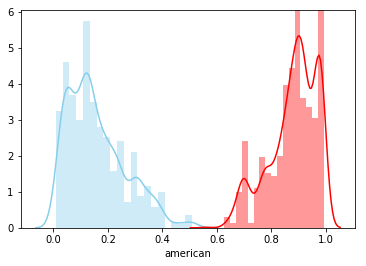

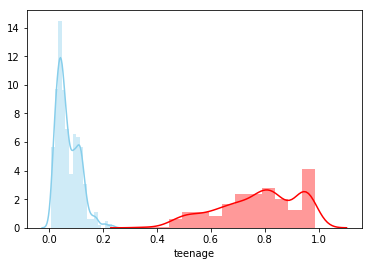

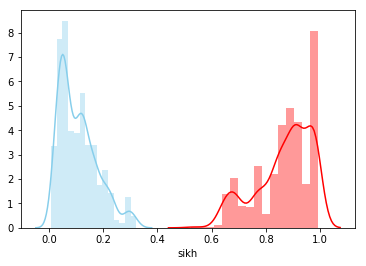

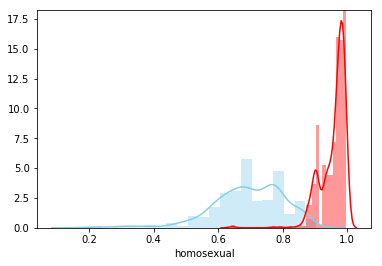

In [27]:
# Plot toxicity distributions

def plot_histogram(identity):
    toxic_scores = balanced_madlibs.query(identity + ' == True & label_bool == True')['RockV5_1:TOXICITY']
    non_toxic_scores = balanced_madlibs.query(identity + ' == True & label_bool == False')['RockV5_1:TOXICITY']
    print(len(non_toxic_scores))
    print(non_toxic_scores[0:5])
    sns.distplot( non_toxic_scores , color="skyblue", axlabel=identity)
    sns.distplot( toxic_scores , color="red", axlabel=identity)
    plt.figure()

# These are the identities we intentionally skewed
for identity in ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer']:
    plot_histogram(identity)

# These identities surprising did better with normed pinned auc
for identity in ['canadian', 'japanese', 'american', 'teenage']:
    plot_histogram(identity)
    
# These identities did a little worse
for identity in ['sikh', 'homosexual']:
    plot_histogram(identity)

In [28]:
# both skews should drop the same number of records
def get_skew_size(balanced, subgroup, label):
    return len(balanced[balanced[subgroup] & ~balanced[label]]) // 2

def skew_group(balanced, subgroup, label):
    non_toxic_subgroup_items = balanced[balanced[subgroup] & ~balanced[label]]
    drop_indices = np.random.choice(
        non_toxic_subgroup_items.index, get_skew_size(balanced, subgroup, label), replace=False)
    #print('skew_group len ' + str(len(drop_indices)))
    return balanced.drop(drop_indices)

# def skew_group_evenly(balanced, subgroup, label):
#     subgroup_items = balanced[balanced[subgroup]]
#     drop_indices = np.random.choice(
#         subgroup_items.index, get_skew_size(balanced, subgroup, label), replace=False)
#     #print('skew_group_evenly len ' + str(len(drop_indices)))
#     return balanced.drop(drop_indices)

In [29]:
#get_skew_size(balanced_madlibs, 'gay', 'label_bool')
#len(balanced_madlibs[balanced_madlibs['gay'] & ~balanced_madlibs['label_bool']])
757 // 2


378

## This writes a CSV with metrics for each iteration (not yet averaged)

In [30]:
def run_iterations(model_and_attribute_name,
                   num_iterations,
                   identity_array,
                   include_asegs,
                   output_csv_path):
    LABEL_NAME = 'label_bool'
    df = pd.DataFrame()
    for i in xrange(num_iterations):
        #print out some steps along the way just to keep track of progress
        if i % 10 == 0:
            print('%d iterations complete' % i)
            
        unbalanced_madlibs = balanced_madlibs
        balanced_madlibs_modified = pd.DataFrame.copy(balanced_madlibs)
        
        for group in identity_array:
            unbalanced_madlibs = skew_group(unbalanced_madlibs, group, LABEL_NAME)

        balanced_pinned_auc_results = model_bias_analysis.per_subgroup_aucs(balanced_madlibs_modified, terms, [[model_and_attribute_name]], LABEL_NAME, include_asegs)
        unbalanced_pinned_auc_results = model_bias_analysis.per_subgroup_aucs(unbalanced_madlibs, terms, [[model_and_attribute_name]], LABEL_NAME, include_asegs)
        
        df_dict = {
            'iteration': i,
            'subgroup': list(balanced_pinned_auc_results.subgroup),
            # balanced results    
            'pinned_auc_balanced_set':  [a[0] for a in balanced_pinned_auc_results[model_and_attribute_name + '_aucs']],
            'normed_pinned_auc_balanced_set': [a[0] for a in balanced_pinned_auc_results[model_and_attribute_name + '_normalized_pinned_aucs']],
            'within_subgroup_mwus_balanced_set': [a[0] for a in balanced_pinned_auc_results[model_and_attribute_name + '_within_subgroup_mwus']],
            'cross_subgroup_negative_mwus_balanced_set': [a[0] for a in balanced_pinned_auc_results[model_and_attribute_name + '_cross_subgroup_negative_mwus']],
            'cross_subgroup_positive_mwus_balanced_set': [a[0] for a in balanced_pinned_auc_results[model_and_attribute_name + '_cross_subgroup_positive_mwus']],
            'balanced_positive_aegs': [a[0] for a in balanced_pinned_auc_results[model_and_attribute_name + '_within_positive_label_mwus']],
            'balanced_negative_aegs': [a[0] for a in balanced_pinned_auc_results[model_and_attribute_name + '_within_negative_label_mwus']],
            # unbalanced results
            'pinned_auc_unbalanced_set': [a[0] for a in unbalanced_pinned_auc_results[model_and_attribute_name + '_aucs']],
            'normed_pinned_auc_unbalanced_set': [a[0] for a in unbalanced_pinned_auc_results[model_and_attribute_name + '_normalized_pinned_aucs']],
            'within_subgroup_mwus_unbalanced_set': [a[0] for a in unbalanced_pinned_auc_results[model_and_attribute_name + '_within_subgroup_mwus']],
            'cross_subgroup_negative_mwus_unbalanced_set': [a[0] for a in unbalanced_pinned_auc_results[model_and_attribute_name + '_cross_subgroup_negative_mwus']],
            'cross_subgroup_positive_mwus_unbalanced_set': [a[0] for a in unbalanced_pinned_auc_results[model_and_attribute_name + '_cross_subgroup_positive_mwus']],
            'unbalanced_positive_aegs': [a[0] for a in unbalanced_pinned_auc_results[model_and_attribute_name + '_within_positive_label_mwus']],
            'unbalanced_negative_aegs': [a[0] for a in unbalanced_pinned_auc_results[model_and_attribute_name + '_within_negative_label_mwus']],
        }
        columns = ['iteration', 'subgroup', 'pinned_auc_balanced_set', 'pinned_auc_unbalanced_set',
                   'normed_pinned_auc_balanced_set', 'normed_pinned_auc_unbalanced_set',
                   'within_subgroup_mwus_balanced_set', 'within_subgroup_mwus_unbalanced_set',
                   'cross_subgroup_negative_mwus_balanced_set', 'cross_subgroup_negative_mwus_unbalanced_set',
                   'cross_subgroup_positive_mwus_balanced_set', 'cross_subgroup_positive_mwus_unbalanced_set',
                   'balanced_positive_aegs', 'balanced_negative_aegs', 'unbalanced_positive_aegs',
                   'unbalanced_negative_aegs']
        
        if include_asegs:
            df_dict.update({
                'balanced_positive_asegs': [a[0]for a in balanced_pinned_auc_results[model_and_attribute_name + '_positive_asegs']],
                'balanced_negative_asegs': [a[0] for a in balanced_pinned_auc_results[model_and_attribute_name + '_negative_asegs']],
                'unbalanced_positive_asegs': [a[0] for a in unbalanced_pinned_auc_results[model_and_attribute_name + '_positive_asegs']],
                'unbalanced_negative_asegs': [a[0] for a in unbalanced_pinned_auc_results[model_and_attribute_name + '_negative_asegs']]
            })
            columns += ['balanced_positive_asegs', 'balanced_negative_asegs',
                        'unbalanced_positive_asegs', 'unbalanced_negative_asegs']

        df = df.append(pd.DataFrame(df_dict, columns=columns), ignore_index=True)
        df['pinned_auc_diff'] = df['pinned_auc_balanced_set'] - df['pinned_auc_unbalanced_set']
        df['normed_pinned_auc_diff'] = df['normed_pinned_auc_balanced_set'] - df['normed_pinned_auc_unbalanced_set']
    df.to_csv(output_csv_path + '.csv', index=False)
    print('wrote file ' + output_csv_path + '.csv')
    
    
    mean_df = df.groupby('subgroup').mean()
    mean_df.to_csv(output_csv_path + '_mean.csv')

In [32]:
identity = 'gay'
include_asegs = True
num_iterations = 100

for model_name in ['Rock', 'RockV6_1']:
    csv_file = '%s_skew_%s_%d_iterations' % (model_name, identity, num_iterations)
    run_iterations(model_name + ':TOXICITY', num_iterations, [identity], include_asegs, csv_file)
    print(model_name + ' finished')

0 iterations complete
10 iterations complete
20 iterations complete
30 iterations complete
40 iterations complete
50 iterations complete
60 iterations complete
70 iterations complete
80 iterations complete
90 iterations complete
wrote file Rock_skew_gay_100_iterations.csv
Rock finished
0 iterations complete
10 iterations complete
20 iterations complete
30 iterations complete
40 iterations complete
50 iterations complete
60 iterations complete
70 iterations complete
80 iterations complete
90 iterations complete
wrote file RockV6_1_skew_gay_100_iterations.csv
RockV6_1 finished


## Average metrics from across runs

In [ ]:
def print_table_from_csv(filepath, use_absolute_value):
    # This code does the absolute value BEFORE grouping + taking the mean
    # Copy is needed to not affect the original columns (by setting absolute values)
    abs_df = pd.read_csv(filepath)
    if use_absolute_value:
        abs_df['normed_pinned_auc_diff'] = abs_df['normed_pinned_auc_diff'].abs()
        abs_df['pinned_auc_diff'] = abs_df['pinned_auc_diff'].abs()
    mean_columns = ['subgroup', 'normed_pinned_auc_diff', 'pinned_auc_diff']
    mean_df = abs_df[mean_columns].groupby('subgroup').mean()

    if use_absolute_value:
        normed_pinned_auc_diff_abs = mean_df['normed_pinned_auc_diff'].abs()
        pinned_auc_diff_abs = mean_df['pinned_auc_diff'].abs()
    else:
        normed_pinned_auc_diff_abs = mean_df['normed_pinned_auc_diff']
        pinned_auc_diff_abs = mean_df['pinned_auc_diff']
    mean_df['is_abs_normed_less?'] = np.where(normed_pinned_auc_diff_abs < pinned_auc_diff_abs, '', 'NO')
    mean_df['how_much_less?'] = pinned_auc_diff_abs - normed_pinned_auc_diff_abs

    return mean_df.sort_values('how_much_less?', ascending=False)

In [ ]:
print_table_from_csv('mann_whitney_analysis_skew_queer_only_skewed_balanced_set_no_sampling.csv', False)